In [1]:
import numpy as np
import seaborn as sns
import locale
#locale.setlocale(locale.LC_NUMERIC, 'ru_RU.UTF-8')
import matplotlib.pyplot as plt
from matplotlib import cm
#plt.rcParams['axes.formatter.use_locale'] = True
#plt.rcParams["axes.formatter.use_mathtext"] = True
from scipy.linalg import solve
from scipy.stats import norm
import time
from math import ceil
import numba as nb
from numba import jit, njit, prange
import pandas as pd

%config InlineBackend.figure_formats = ['retina']

# Параметры процесса

In [2]:
seed = 999

np.random.seed(seed)

rng = np.random.default_rng(seed=seed)
@njit()
def set_seed(seed):
    np.random.seed(seed)

set_seed(seed)

In [3]:
Lambda = np.array([[0, 1/20, 0, 1/1000],
                   [1/5, 0, 1/15, 1/1000],
                   [0, 1/3, 0, 1/1000],
                   [1/30, 0, 0, 0]])

for i in range(Lambda.shape[0]):
    Lambda[i][i] = -np.sum(Lambda[i])

#количество состояний
N = Lambda.shape[0]

#правая граница временного промежутка
T = 150

ht = 1e-4 #шаг моделирования
ht0 = np.sqrt(ht)

N_h = 100
ht1 = ht * N_h #шаг фильтрации
ht10 = np.sqrt(ht1)
#сетка
t_net0 = np.array([t*ht1 for t in range(ceil(T/ht1))])

_, _, vh = np.linalg.svd(Lambda.T)
p0 = vh[-1]
p0 /= np.sum(p0)
print(p0)

[0.74794044 0.18587044 0.0370629  0.02912621]


In [4]:
#интервалы для Y
y1_intervals = np.array([[0.015, 0.020],
                         [0.018, 0.023],
                         [0.022, 0.027],
                         [0.024, 0.029]])

y2_intervals = np.array([[0.0005, 0.0015],
                         [0.0005, 0.0015],
                         [0.01, 0.1],
                         [0.05, 0.2]])

#параметры сетки
num1 = 100 #число узлов
a1 = np.min(y1_intervals)
b1 = np.max(y1_intervals)
net1 = np.linspace(a1, b1, num=num1)
delta1 = (b1 - a1) / num1 #шаг по координате

num2 = 1000
a2 = np.min(y2_intervals)
b2 = np.max(y2_intervals)
net2 = np.linspace(a2, b2, num=num2)
delta2 = (b2 - a2) / num2 #шаг по координате

#декартово произведение
def cartesian_product(arrays):
    la = len(arrays)
    arr = np.empty([len(a) for a in arrays] + [la])
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

#M-мерная сетка
M_net = cartesian_product([net1, net2])
#M_net = net1
print(M_net.shape)

(100000, 2)


# Генерация $\theta$ и $Y$

In [5]:
#генерация марковской цепи и наблюдений (по скачкам)
@njit(fastmath=True)
def choice(a, p):
    return a[np.searchsorted(np.cumsum(p), np.random.uniform())]

#генерация Y по состоянию
#равномерные
@njit(fastmath=True)
def get_y_uniform(state):
     return [np.random.uniform(y1_intervals[state][0], y1_intervals[state][1]), 
             np.random.uniform(y2_intervals[state][0], y2_intervals[state][1])]

#треугольные по краям
@njit(fastmath=True)
def get_y_triangular(state):
    if state == 0:
        return [np.random.triangular(y1_intervals[state][0], 
                                     y1_intervals[state][1], 
                                     y1_intervals[state][1]),
                np.random.triangular(y2_intervals[state][0], 
                                     y2_intervals[state][1], 
                                     y2_intervals[state][1])]
    elif state == N-1:
        return [np.random.triangular(y1_intervals[state][0], 
                                     y1_intervals[state][0], 
                                     y1_intervals[state][1]),
                np.random.triangular(y2_intervals[state][0], 
                                     y2_intervals[state][0], 
                                     y2_intervals[state][1])]
    else:
        return [np.random.uniform(y1_intervals[state][0], y1_intervals[state][1]), 
                np.random.uniform(y2_intervals[state][0], y2_intervals[state][1])]


points1 = np.array([[y1_intervals[state][0], 
                    (y1_intervals[state][0] + y1_intervals[state][1])/2, 
                     y1_intervals[state][1]] for state in range(N)])
points2 = np.array([[y2_intervals[state][0], 
                    (y2_intervals[state][0] + y2_intervals[state][1])/2, 
                     y2_intervals[state][1]] for state in range(N)])
p_3point = np.array([1/3, 1/3, 1/3])
@njit(fastmath=True)
def get_y_3point(state):
    return [choice(points1[state], p_3point),
            choice(points2[state], p_3point)]

#размерность Y
M = len(get_y_uniform(0))

lam = np.diagonal(Lambda)

@jit(nopython=True, fastmath=True)
def sparse_mc(p0, Lambda, T, get_y): 
    #начальные условия и т.п.
    res_theta = []
    res_y = []
    res_t = []
    O = np.empty(p0.shape[0])
    J = np.zeros(Lambda.shape)
    k = np.arange(p0.shape[0])

    state = choice(k, p0)
    t = 0.
    Y = get_y(state)
    res_theta.append(state)
    res_y.append(Y)

    pr = [-Lambda[state][k != state] / lam[state] for state in k]
    state_exc = [k[k != state] for state in k]

    while True:
        #генерирую скачок
        tmp = np.random.exponential(-1/lam[state])
        t += tmp
        if t <= T:
            pr_state = state
            state = choice(state_exc[pr_state], pr[pr_state])
            Y = get_y(state)
            res_theta.append(state)
            res_y.append(Y)
            #добавляю момент ИЗМЕНЕНИЯ состояния
            #т.е. theta = theta[i] от t[i] до t[i+1]
            res_t.append(t)
        else:
            res_t.append(T)
            break
    return np.array(res_theta, dtype=np.int64), np.array(res_y), np.array(res_t)

In [6]:
start = time.time()
theta, y, t = sparse_mc(p0, Lambda, T, get_y_uniform)
stop = time.time()
print("Время генерации theta и Y:", stop-start)

Время генерации theta и Y: 3.0456018447875977


# Перевод в дискретное представление по времени

In [7]:
#переводит кусочно-постоянное представление в дискретное
@njit(fastmath=True)
def to_discrete(jumps, time, T, h):
    res = np.empty((ceil(T/h),) + np.shape(jumps[0]), dtype=jumps.dtype)
    j = 0
    i = 0
    for s in time:
        for k in range(j, ceil(s/h)):
            res[k] = jumps[i]
        j = k + 1
        i += 1
    for k in range(j, ceil(T/h)):
        res[k] = jumps[-1]
    return res

In [8]:
start = time.time()
dtmc = to_discrete(theta, t, T, ht)
dty = to_discrete(y, t, T, ht)
stop = time.time()
print('Время перевода в дискретное представление (шаг h={}):'.format(ht), stop-start)

Время перевода в дискретное представление (шаг h=0.0001): 1.0645184516906738


# Генерация наблюдений

In [9]:
L = 1 #размерность g
@njit(nogil=True, cache=True)
def g(t, y, theta):
    return (1*y[0]).reshape(1, -1)

@njit(nogil=True, cache=True)
def make_xi(dty, dtmc, ht, ht0, T, sigma):
    xi = np.empty((dty.shape[0], L))
    G = g(-1, dty.T, -1).T
    xi[0] = G[0]*ht
    for t in range(1, dty.shape[0]):
        xi[t] = xi[t-1] + G[t-1]*ht + sigma*ht0*np.random.normal(0, 1, L)
    return xi

R = 1 #размерность h
@njit(fastmath=True, nogil=True, cache=True)
def h(t, y, theta):
    return (y[1] / y[0]).reshape(1, -1)

@njit(fastmath=True, nogil=True, cache=True)
def make_eta(dty, dtmc, ht, T):
    eta_jumps = []
    pr = ht*h(t_net0, dty.T, dtmc.T)
    a = np.array([True, False])
    for t in range(np.floor(T/ht)):
        if choice(a, np.array([pr[0][t], 1-pr[0][t]])):
            eta_jumps.append((t*ht, 0))
    return np.array(eta_jumps)

In [10]:
sigma = 0.0005

In [11]:
start = time.time()
xi = make_xi(dty, dtmc, ht, ht0, T, sigma)
eta = make_eta(dty, dtmc, ht, T)
stop = time.time()
print('Время генерации наблюдений (шаг h={}):'.format(ht), stop-start)

Время генерации наблюдений (шаг h=0.0001): 0.6566681861877441


# Численное решение уравнения для условной плотности:

In [12]:
#плотности
@njit(fastmath=True, nogil=True, cache=True)
def norm(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)
@njit(fastmath=True, nogil=True, cache=True)
def unif(x, a, b):
    return (x <= b) * (x >= a) / (b - a)

@np.vectorize()
def triang1(x, a, b):
    if x < a:
        return 0
    elif x > b:
        return 0
    else:
        return 2 * (x - a) / (b - a)**2
@np.vectorize()
def triang2(x, a, b):
    if x < a:
        return 0
    elif x > b:
        return 0
    else:
        return 2 * (b - x) / (b - a)**2

In [13]:
#условная плотность y при условии theta
pi_uniform = np.empty((N, M_net.shape[0]))
for n in range(N):
    pi_uniform[n] = unif(M_net.T[0], y1_intervals[n][0], y1_intervals[n][1]) * unif(M_net.T[1], y2_intervals[n][0], y2_intervals[n][1])

pi_triangular = np.empty((N, M_net.shape[0]))
for n in range(1, N-1):
    pi_triangular[n] = pi_uniform[n]

pi_triangular[0] = triang1(M_net.T[0],
                           y1_intervals[0][0],
                           y1_intervals[0][1]) * triang1(M_net.T[1],
                                                         y2_intervals[0][0],
                                                         y2_intervals[0][1])

pi_triangular[N-1] = triang2(M_net.T[0],
                             y1_intervals[N-1][0],
                             y1_intervals[N-1][1]) * triang2(M_net.T[1],
                                                             y2_intervals[N-1][0],
                                                             y2_intervals[N-1][1])

pi_3point = np.zeros((N, M_net.shape[0]))
for n in range(N):
    tmp1 = np.zeros(net1.shape[0])
    tmp2 = np.zeros(net2.shape[0])
    tmp1[np.argmin(np.abs(net1 - y1_intervals.T[0][n]))] = 1
    tmp1[np.argmin(np.abs(net1 - y1_intervals.T[1][n]))] = 1
    tmp1[np.argmin(np.abs(net1 - (y1_intervals.T[0][n] + y1_intervals.T[1][n])/2))] = 1
    tmp1 /= 3*delta1
    tmp2[np.argmin(np.abs(net2 - y2_intervals.T[0][n]))] = 1
    tmp2[np.argmin(np.abs(net2 - y2_intervals.T[1][n]))] = 1
    tmp2[np.argmin(np.abs(net2 - (y2_intervals.T[0][n] + y2_intervals.T[1][n])/2))] = 1
    tmp2 /= 3*delta2
    pi_3point[n] = cartesian_product([tmp1, tmp2]).prod(axis=1)

In [14]:
#добавляю скачки eta к временной сетке 
t_net = np.sort(np.unique(np.concatenate((t_net0, eta[:,0]))))

#средние y
y_means_uniform = np.array([[(y1_intervals[n][1] + y1_intervals[n][0])/2 for n in range(N)],
                            [(y2_intervals[n][1] + y2_intervals[n][0])/2 for n in range(N)]])

y_means_triang = y_means_uniform.copy()
y_means_triang.T[0][0] = (2*y1_intervals[0][1] + y1_intervals[0][0])/3
y_means_triang.T[0][1] = (2*y2_intervals[0][1] + y2_intervals[0][0])/3
y_means_triang.T[N-1][0] = (y1_intervals[N-1][1] + 2*y1_intervals[N-1][0])/3
y_means_triang.T[N-1][1] = (y2_intervals[N-1][1] + 2*y2_intervals[N-1][0])/3

y_means_3point = y_means_uniform.copy()

#вспомогательные переменные
lam = np.diagonal(Lambda)
Lam = Lambda - np.diag(lam)

delta = delta1*delta2

In [15]:
@njit()
def get_index(eta, t_net, t_net0):
    index = []
    for t in range(t_net.shape[0]):
        eta_flag = t_net[t] in eta[:,0]
        index.append(eta_flag and not (t_net[t] in t_net0))
    return np.array(index)

index = get_index(eta, t_net, t_net0)

In [16]:
M1_psi = 0
M2_psi = 0

In [17]:
@njit(fastmath=True, nogil=True)
def filter(pi, y_means, xi, eta, t_net, delta, index,
           Lam=Lam, lam=lam, p0=p0, 
           N=N, M=M, L=L, R=R,
           M_net=M_net, t_net0=t_net0, ht=ht,
           h=h, g=g, sigma=sigma, norm=norm, rec=True, M1=M1_psi, M2=M2_psi):
    psi = np.zeros((N, M_net.shape[0])) #условная плотность
    psi_rec = np.zeros((M2-M1, N, M_net.shape[0]))
    theta_opt = np.zeros((t_net.shape[0], N)) #оценка theta
    y_opt = np.zeros((t_net.shape[0], M_net.shape[1])) #оценка Y

    psi_pred = np.zeros((N, M_net.shape[0])) #прогноз плотности
    ro = np.zeros((N, M_net.shape[0])) #совместная плотность theta, Y и xi относительно наблюдений
    norm_pdf = np.zeros((N, M_net.shape[0])) #условная Гауссиана

    eta_flag = index[0]
    jump_number = -1

    G = g(-1, M_net.T, -1)
    H = h(-1, M_net.T, -1).T

    #начальные условия
    h_opt = np.zeros(R)
    for n in prange(N):
        psi[n] = pi[n] * p0[n]
        #H = h(0, M_net.T, n).T
        h_opt += psi[n] @ H * delta

    theta_opt[0] = p0
    y_opt[0] = y_means @ p0

    for t in range(1, t_net.shape[0]):
        #обрабатываю момент скачка
        jump_number = jump_number + index[t]

        h1 = t_net[t] - t_net[t-1]
        h10 = np.sqrt(h1)

        #прогноз
        h_residual = np.zeros((N, M_net.shape[0], R))
        for n in prange(N):
            h_residual[n] = H - h_opt
            #h(t_net[t-1], M_net.T, n).T - h_opt
            psi_pred[n] = ((psi[n]*(1 + lam[n]*h1) + np.sum(Lam.T[n] * theta_opt[t-1])*pi[n]*h1).T * np.exp(-h1*np.sum(h_residual[n], axis=1))).T

        #коррекция
        d_xi = xi[int(t_net[t] / ht)] - xi[int(t_net[t-1] / ht)]
        for n in prange(N):
            norm_pdf[n] = np.ones(M_net.shape[0])
            #G = g(t_net[t], M_net.T, n)
            for m in range(L):
                norm_pdf[n] = norm_pdf[n] * norm(d_xi[m], h1*G[m], sigma*h10)
            ro[n] = norm_pdf[n] * psi_pred[n]

        #если ro ушло в 0, пользуемся прогнозом
        s = np.sum(ro)*delta
        if s == 0:
            psi = psi_pred
        else:
            psi = ro / s

        #дробный шаг для считающих наблюдений
        if index[t]:
            #достаю номера скакнувших компонент eta
            jumped = eta.T[1][eta.T[0][jump_number] == eta.T[0]]
            for i in jumped:
                for n in prange(N):
                    #коррекция
                    psi[n] = psi_pred[n]*(1 + h_residual[n].T[int(i)] * h_opt[int(i)]**(-1))
            #если всё сломалось
            s = np.sum(psi)*delta
            if s == 0:
                psi = psi_pred
            else:
                psi /= s

        if rec and t >= M1 and t < M2:
            psi_rec[t-M1] = psi

        #оценка theta и Y
        h_opt = np.zeros(R)
        for n in range(N):
            theta_opt[t][n] = np.sum(psi[n])*delta
            #y_opt[t] += np.sum(M_net.T * psi[t][n], axis=1)*delta
            #H = h(t_net[t], M_net.T, n).T
            y_opt[t] +=  psi[n] @ M_net *delta
            h_opt += psi[n] @ H *delta
        #нормирую
        theta_opt[t]  /= np.sum(theta_opt[t])

    return theta_opt, y_opt, psi_rec, index

@njit(fastmath=True, nogil=True, parallel=True)
def filter_cont(pi, y_means, xi, t_net, delta):
    psi = np.zeros((N, M_net.shape[0])) #условная плотность
    theta_opt = np.zeros((t_net.shape[0], N)) #оценка theta
    y_opt = np.zeros((t_net.shape[0], M_net.shape[1])) #оценка
    psi_pred = np.zeros((N, M_net.shape[0])) #прогноз плотности
    ro = np.zeros((N, M_net.shape[0])) #совместная плотность theta, Y и xi относительно наблюдений
    norm_pdf = np.zeros((N, M_net.shape[0])) #условная Гауссиана
    G = g(-1, M_net.T, -1)
    for n in range(N):
        psi[n] = pi[n] * p0[n]
    theta_opt[0] = p0
    y_opt[0] = y_means @ p0
    for t in range(1, t_net.shape[0]):
        h1 = t_net[t] - t_net[t-1]
        h10 = np.sqrt(h1)
        for n in prange(N):
            psi_pred[n] = (psi[n]*(1 + lam[n]*h1) + np.sum(Lam.T[n] * theta_opt[t-1])*pi[n]*h1).T
        d_xi = xi[int(t_net[t] / ht)] - xi[int(t_net[t-1] / ht)]
        for n in prange(N):
            norm_pdf[n] = np.ones(M_net.shape[0])
            #G = g(t_net[t], M_net.T, n)
            for m in range(L):
                norm_pdf[n] *= norm(d_xi[m], h1*G[m], sigma*h10)
            ro[n] = norm_pdf[n] * psi_pred[n]
        s = np.sum(ro)*delta
        if s == 0:
            psi = psi_pred
        else:
            psi = ro / s
        for n in range(N):
            theta_opt[t][n] = np.sum(psi[n])*delta
            y_opt[t] += psi[n] @ M_net * delta
        theta_opt[t] /= np.sum(theta_opt[t])
    return theta_opt, y_opt, psi

In [18]:
E_y1 = y_means_uniform[0]

E_y2 = y_means_uniform[1]

E_y2_div_y1 = E_y2 * np.log(y1_intervals.T[1] / y1_intervals.T[0]) / (y1_intervals.T[1] - y1_intervals.T[0])

E_y1_sq = (y1_intervals.T[0]**2 + y1_intervals.T[0]*y1_intervals.T[1] + y1_intervals.T[1]**2)/3

E_y2_sq = (y2_intervals.T[0]**2 + y2_intervals.T[0]*y2_intervals.T[1] + y2_intervals.T[1]**2)/3

E_y2_div_y1_sq = E_y2_sq / (y1_intervals.T[0]*y1_intervals.T[1])

E_y2_sq_div_y1 = E_y2_sq  * np.log(y1_intervals.T[1] / y1_intervals.T[0]) / (y1_intervals.T[1] - y1_intervals.T[0])

Dx = np.zeros((4*N, 4*N))

Dx[0:N, 0:N] = Lambda.T

Dx[N:2*N, 0:N] = np.diag(E_y1) @ Lam.T
Dx[2*N:3*N, 0:N] = np.diag(E_y2) @ Lam.T
Dx[3*N:4*N, 0:N] = np.diag(E_y2_div_y1) @ Lam.T

Dx[N:2*N, N:2*N] = np.diag(lam)
Dx[2*N:3*N, 2*N:3*N] = np.diag(lam)
Dx[3*N:4*N, 3*N:4*N] = np.diag(lam)

b = np.zeros((4*N, 4*N))

b[0:N, 0:N] = np.diag(Lambda.T @ p0) - Lambda.T @ np.diag(p0) - np.diag(p0) @ Lambda
tmp = np.diag(Lam.T @ p0) - np.diag(p0) @ Lam - Lambda.T @ np.diag(p0) 
b[0:N, N:2*N] = tmp @ np.diag(E_y1)
b[0:N, 2*N:3*N] = tmp @ np.diag(E_y2)
b[0:N, 3*N:4*N] = tmp @ np.diag(E_y2_div_y1)

tmp1 = np.diag(Lam.T @ p0) - np.diag(p0) @ np.diag(lam)
tmp2 = np.diag(p0) @ Lam + Lam.T @ np.diag(p0)
b[N:2*N, N:2*N] = np.diag(E_y1_sq) @ tmp1 - np.diag(E_y1) @ tmp2 @ np.diag(E_y1)
b[N:2*N, 2*N:3*N] = np.diag(E_y1) @ np.diag(E_y2) @ tmp1 - np.diag(E_y1) @ tmp2 @ np.diag(E_y2)
b[N:2*N, 3*N:4*N] = np.diag(E_y2) @ tmp1 - np.diag(E_y1) @ tmp2 @ np.diag(E_y2_div_y1)

b[2*N:3*N, 2*N:3*N] = np.diag(E_y2_sq) @ tmp1 - np.diag(E_y2) @ tmp2 @ np.diag(E_y2)
b[2*N:3*N, 3*N:4*N] = np.diag(E_y2_sq_div_y1) @ tmp1 - np.diag(E_y2) @ tmp2 @ np.diag(E_y2_div_y1)

b[3*N:4*N, 3*N:4*N] = np.diag(E_y2_div_y1_sq) @ tmp1 - np.diag(E_y2_div_y1) @ tmp2 @ np.diag(E_y2_div_y1)

for i in range(N):
    for j in range(i):
        b[i*N:(i+1)*N, j*N:(j+1)*N] = b[j*N:(j+1)*N, i*N:(i+1)*N].T

Du = np.zeros((2, 4*N))
Du[0, 1*N:2*N] = np.ones(N)
Du[1, 3*N:4*N] = np.ones(N)

B = np.zeros((2, 2),  dtype=np.float64)
B[0, 0] = sigma**2
B[1, 1] = np.dot(E_y2_div_y1, p0)

k0 = np.zeros((4*N, 4*N))

k0[0:N, 0:N] = np.diag(p0) - np.outer(p0, p0)
k0[0:N, N:2*N] = np.diag(p0*E_y1) - np.outer(p0, p0*E_y1)
k0[0:N, 2*N:3*N] = np.diag(p0*E_y2) - np.outer(p0, p0*E_y2)
k0[0:N, 3*N:4*N] = np.diag(p0*E_y2_div_y1) - np.outer(p0, p0*E_y2_div_y1)

k0[N:2*N, N:2*N] = np.diag(p0*E_y1_sq) - np.outer(p0*E_y1, p0*E_y1)
k0[N:2*N, 2*N:3*N] = np.diag(p0*E_y1*E_y2) - np.outer(p0*E_y1, p0*E_y2)
k0[N:2*N, 3*N:4*N] = np.diag(p0*E_y2) - np.outer(p0*E_y1, p0*E_y2_div_y1)

k0[2*N:3*N, 2*N:3*N] = np.diag(p0*E_y2_sq) - np.outer(p0*E_y2, p0*E_y2)
k0[2*N:3*N, 3*N:4*N] = np.diag(p0*E_y2_sq_div_y1) - np.outer(p0*E_y2, p0*E_y2_div_y1)

k0[3*N:4*N, 3*N:4*N] = np.diag(p0*E_y2_div_y1_sq) - np.outer(p0*E_y2_div_y1, p0*E_y2_div_y1)

for i in range(N):
    for j in range(i):
        k0[i*N:(i+1)*N, j*N:(j+1)*N] = k0[j*N:(j+1)*N, i*N:(i+1)*N].T

In [19]:
np.linalg.eigvals(b)

array([ 2.20638437e-01,  1.28707028e-01,  5.11274943e-02,  5.66575188e-03,
        2.70174077e-04,  2.28997324e-05,  2.12101549e-05,  3.57120723e-07,
        1.95923445e-07,  1.47269336e-07,  1.02227648e-07,  8.40045419e-09,
        4.26596250e-10, -3.85405997e-18,  4.63607606e-11,  4.32477397e-11])

In [20]:
def filter_lin(E_y1, E_y2, E_y2_div_y1,
               Dx, b, Du, B, k0,
               xi, eta, t_net, index,
               Lam=Lam, lam=lam, p0=p0, 
               N=N, M=M, L=L, R=R, ht=ht,
               sigma=sigma):
    theta = np.zeros((t_net.shape[0], N))
    y = np.zeros((t_net.shape[0], M))
    k = np.zeros((t_net.shape[0], 4*N, 4*N),  dtype=np.float64)

    I = np.identity(4*N)

    X = np.zeros(4*N, dtype=np.float64)
    X[0:N] = p0
    X[N:2*N] = p0 * E_y1
    y[0][0] = np.sum(p0 * E_y1)
    X[2*N:3*N] = p0 * E_y2
    y[0][1] = np.sum(p0 * E_y2)
    X[3*N:4*N] = p0 * E_y2_div_y1

    k[0] = k0

    for t in range(1, t_net.shape[0]):
        h = t_net[t] - t_net[t-1]
        
        dU = np.array([(xi[int(t_net[t] / ht), 0] - xi[int(t_net[t-1] / ht), 0]), int(index[t])])
        X_pred = (I + Dx*h) @ X

        gamma = k[t-1] @ Du.T @ np.linalg.inv(B)
        X = X_pred + gamma @ (dU - Du @ X_pred * h)

        k[t] = k[t-1] + h*(Dx @ k[t-1] + k[t-1] @ Dx.T + b - gamma @ B @ gamma.T)

        theta[t] = X[0:N]
        y[t][0] = np.sum(X[N:2*N])
        y[t][1] = np.sum(X[2*N:3*N])
        
    return theta, y, k

theta_l, y_l, k = filter_lin(E_y1, E_y2, E_y2_div_y1, Dx, b, Du, B, k0, xi, eta, t_net, index)

In [21]:
start = time.time()
theta_opt, y_opt, psi, index = filter(pi_uniform, y_means_uniform, xi, eta, np.empty(1), delta, index)
stop = time.time()
print('Время решения уравнения фильрации (шаг h1={}):'.format(ht1), stop-start)

Время решения уравнения фильрации (шаг h1=0.01): 6.883548974990845


In [22]:
start = time.time()
theta_opt, y_opt, psi, index = filter(pi_uniform, y_means_uniform, xi, eta, t_net, delta, index)
stop = time.time()
print('Время решения уравнения фильрации (шаг h1={}):'.format(ht1), stop-start)

Время решения уравнения фильрации (шаг h1=0.01): 195.70983004570007


In [23]:
#start = time.time()
#theta_opt_2, y_opt_2, psi_c = filter_cont(pi_uniform, y_means_uniform, xi, t_net, delta)
#stop = time.time()
#print('Время решения уравнения фильрации (шаг h1={}):'.format(ht1), stop-start)

# Визуализация

In [24]:
sns.set_style('whitegrid')
abc = ['a', 'b', 'c', 'd']

In [25]:
theta_labels = ['$\\theta_t = e_1$', '$\\theta_t = e_2$', 
                '$\\theta_t = e_3$', '$\\theta_t = e_4$']

theta_colors = ['green', 'chocolate', 'darkred', 'black']

def plot_theta(ax, theta, t, theta_labels, theta_colors, T, alpha=0.3):
    start = np.roll(t, 1)
    start[0] = 0
    lines = []
    for n in range(N):
        line = ax.fill_between(np.sort(np.concatenate([start, t])), 0, T, 
                               where=np.repeat((theta==n), 2), 
                               color=theta_colors[n],
                               alpha=alpha, transform=ax.get_xaxis_transform())
        lines.append(line)
    return lines

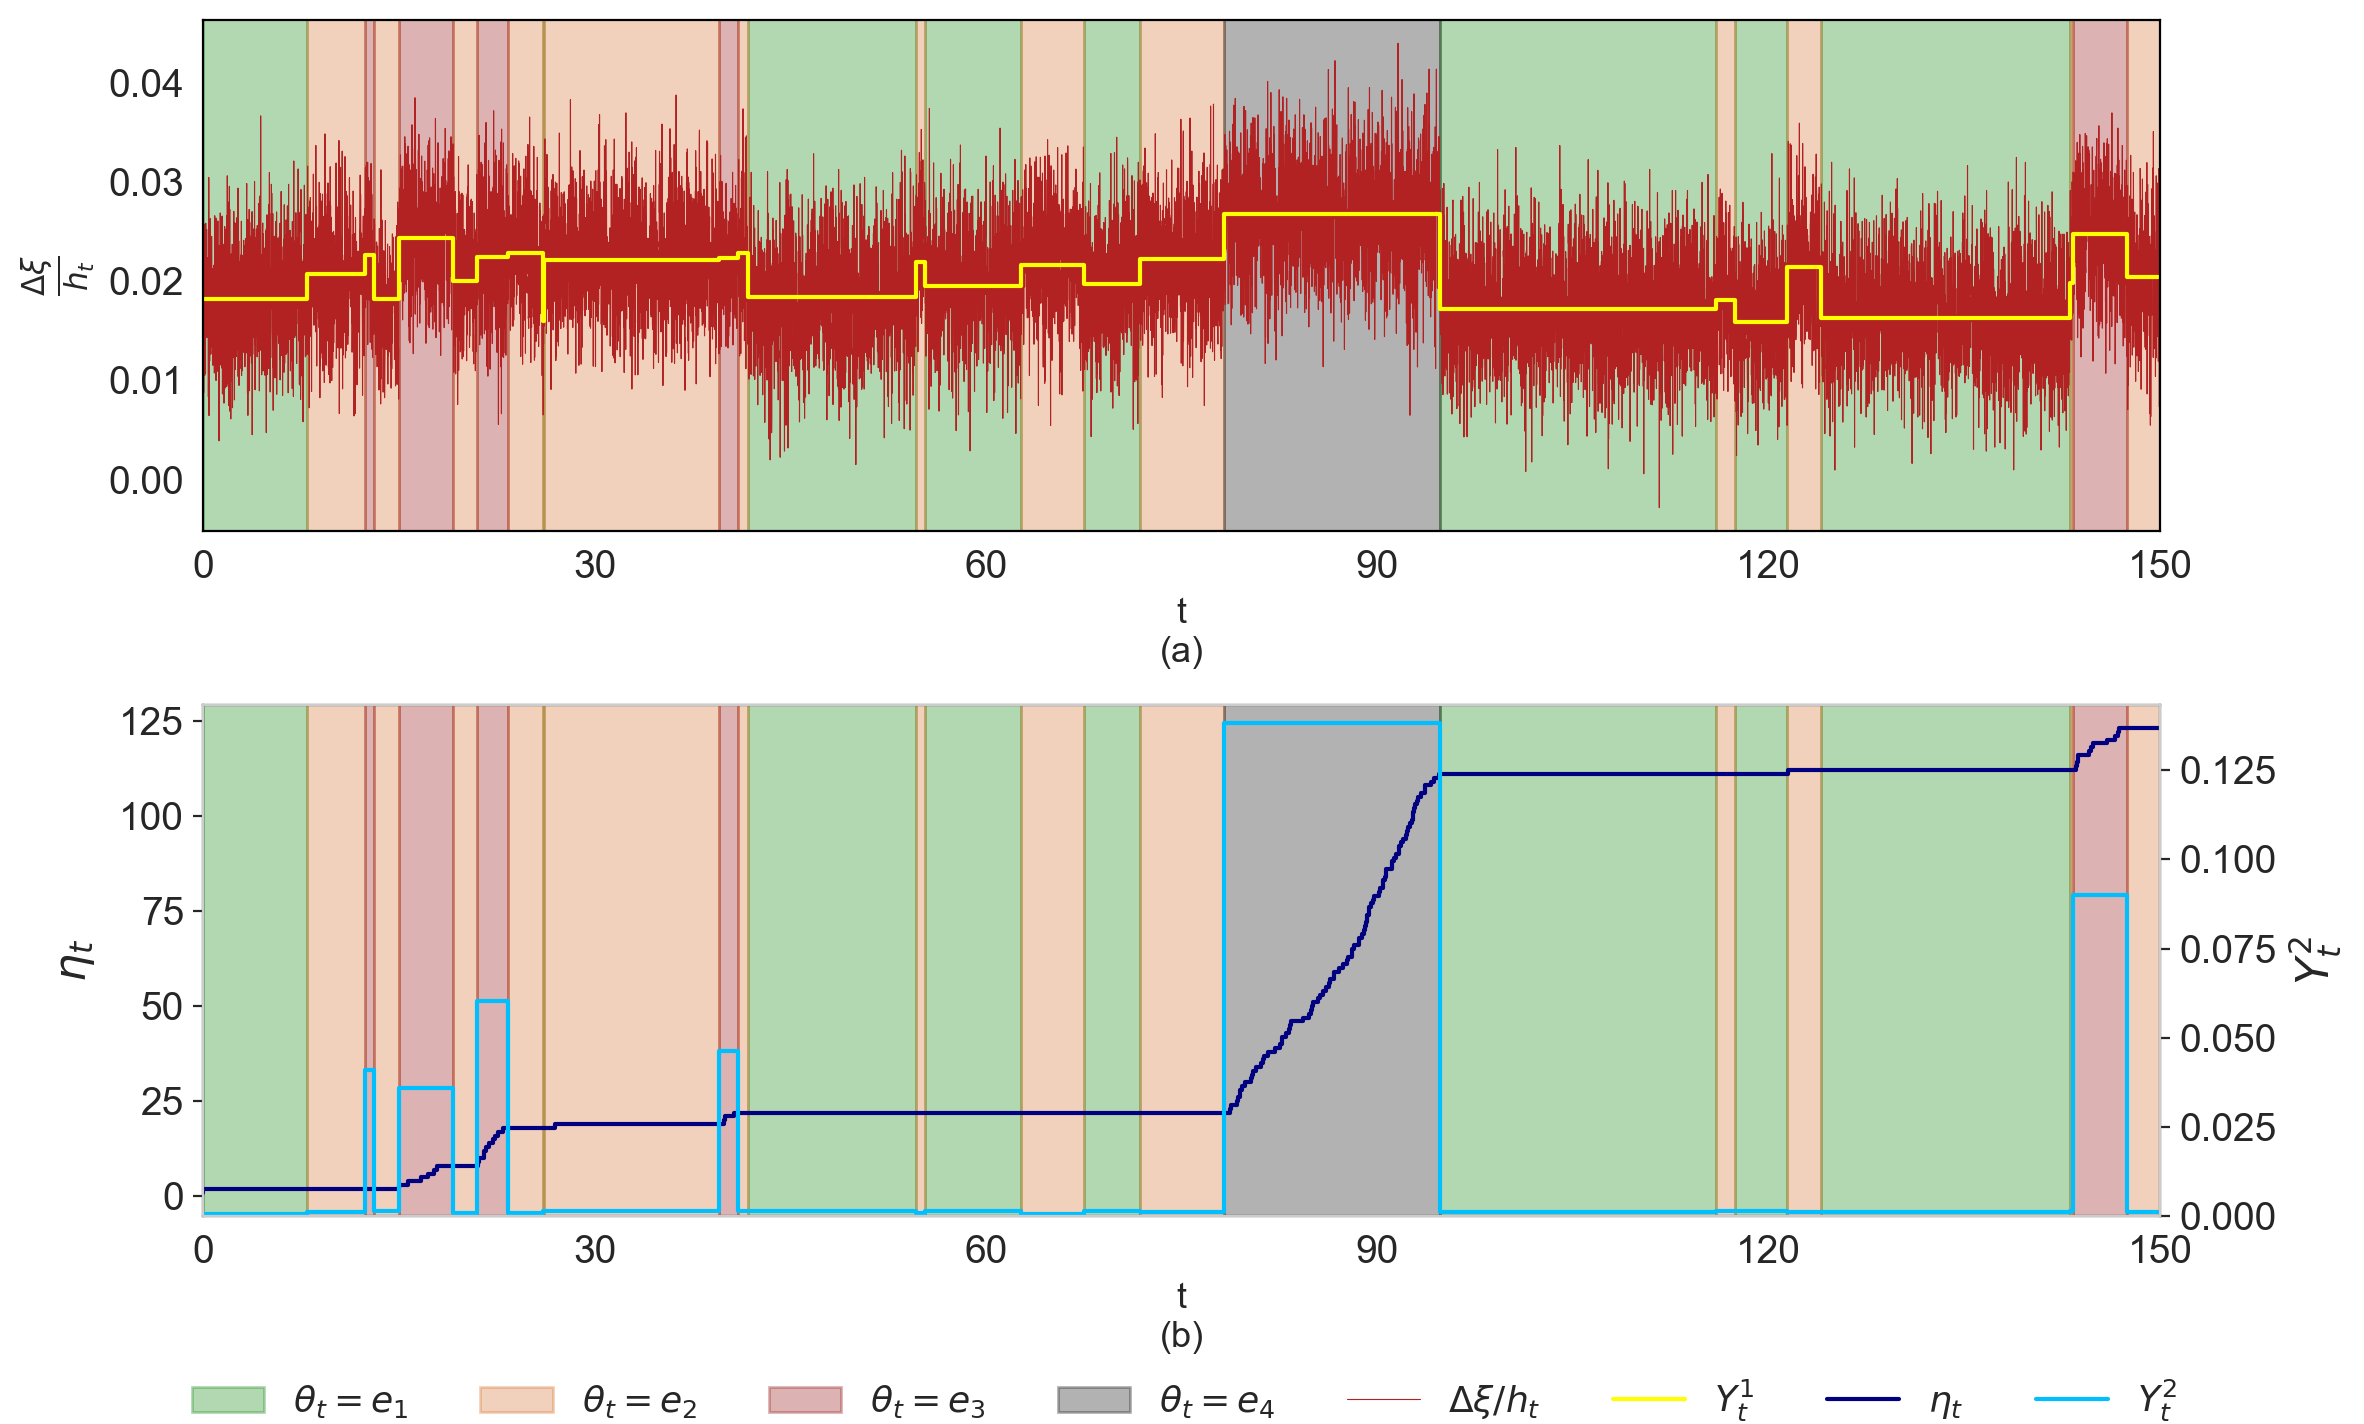

In [26]:
fig, ax = plt.subplots(2, figsize=(12, 7))

#fig.suptitle('Наблюдения')

time_net = np.linspace(0, T, num=ceil(T/ht))

tmp = to_discrete(y.T[1], t, T, ht)
line1, = ax[0].plot(time_net[::N_h][:-1],
                    np.diff(xi.T[0][::N_h]) / ht1, lw=0.4, color='firebrick')
line2, = ax[0].step(np.concatenate([[0], t]), 
                    np.concatenate([[y.T[0][0]], y.T[0]]), color='yellow')
theta_lines = plot_theta(ax[0], theta, t, theta_labels, theta_colors, T)

ax[0].set_xlabel(f't\n({abc[0]})', fontsize=13)
ax[0].set_ylabel('$\\frac{\\Delta \\xi}{h_t}$', fontsize=16)
ax[0].grid()
ax[0].set_xlim(0, T)
ax[0].set_xticks(np.arange(0, T+1, step=30))
ax[0].spines["bottom"].set_color("k")
ax[0].spines["top"].set_color("k")
ax[0].spines["left"].set_color("k")
ax[0].spines["right"].set_color("k")
ax[0].tick_params(labelsize=14)

#ax[0].set_yticks(ticks=[-0.02, 0.025, 0.07])

ax_2 = ax[1].twinx()
ax_2.grid()
line4, = ax_2.step(np.concatenate([[-0.1], t]), np.concatenate([[y.T[1][0]], y.T[1]]),
                   color='deepskyblue')
ax_2.axis([0, T, 0, np.max(y.T[1])+0.005])
ax_2.tick_params(labelsize=14)
ax_2.set_ylabel('$Y_t^2$', fontsize=16)
#ax_2.set_yticks(ticks=np.linspace(0, 0.08, num=3))

line3, = ax[1].step([0] + eta.T[0][1:-1].tolist() + [T], np.arange(eta.shape[0])+1, 
                    color='navy')

line1t, line2t, line3t, line4t = plot_theta(ax[1], theta, t, theta_labels, theta_colors, T)
ax[1].set_xlabel(f't\n({abc[1]})', fontsize=13)
ax[1].set_ylabel('$\\eta_t$', fontsize=16)
ax[1].grid()
ax[1].set_xlim(0, T)
ax[1].set_xticks(np.arange(0, T+1, step=30))
ax[1].spines["bottom"].set_color("k")
ax[1].spines["top"].set_color("k")
ax[1].spines["left"].set_color("k")
ax[1].spines["right"].set_color("k")
ax[1].tick_params(labelsize=14)
#ax[1].set_yticks([0, 25, 50])

#handles = [line1t, line1, 
#           line2t, line2, 
#           line3t, line3,
#           line4t, line4]
handles = [line1t, line2t, line3t, line4t,
           line1, line2, line3, line4]
#labels =  [theta_labels[0], '$\\Delta \\xi/h_t$',
#           theta_labels[1], '$Y^1_t$',
#           theta_labels[2], '$\\eta_t$',
#           theta_labels[3], '$Y_t^2$']

labels = theta_labels + ['$\\Delta \\xi/h_t$', '$Y^1_t$',
                         '$\\eta_t$', '$Y_t^2$']

fig.legend(fontsize=13,
           handles=handles, 
           labels=labels, 
           loc=(0.075, -0.01), 
           ncols=len(labels),
           framealpha=1,
           frameon=False)
fig.tight_layout()
fig.align_ylabels()
plt.show()

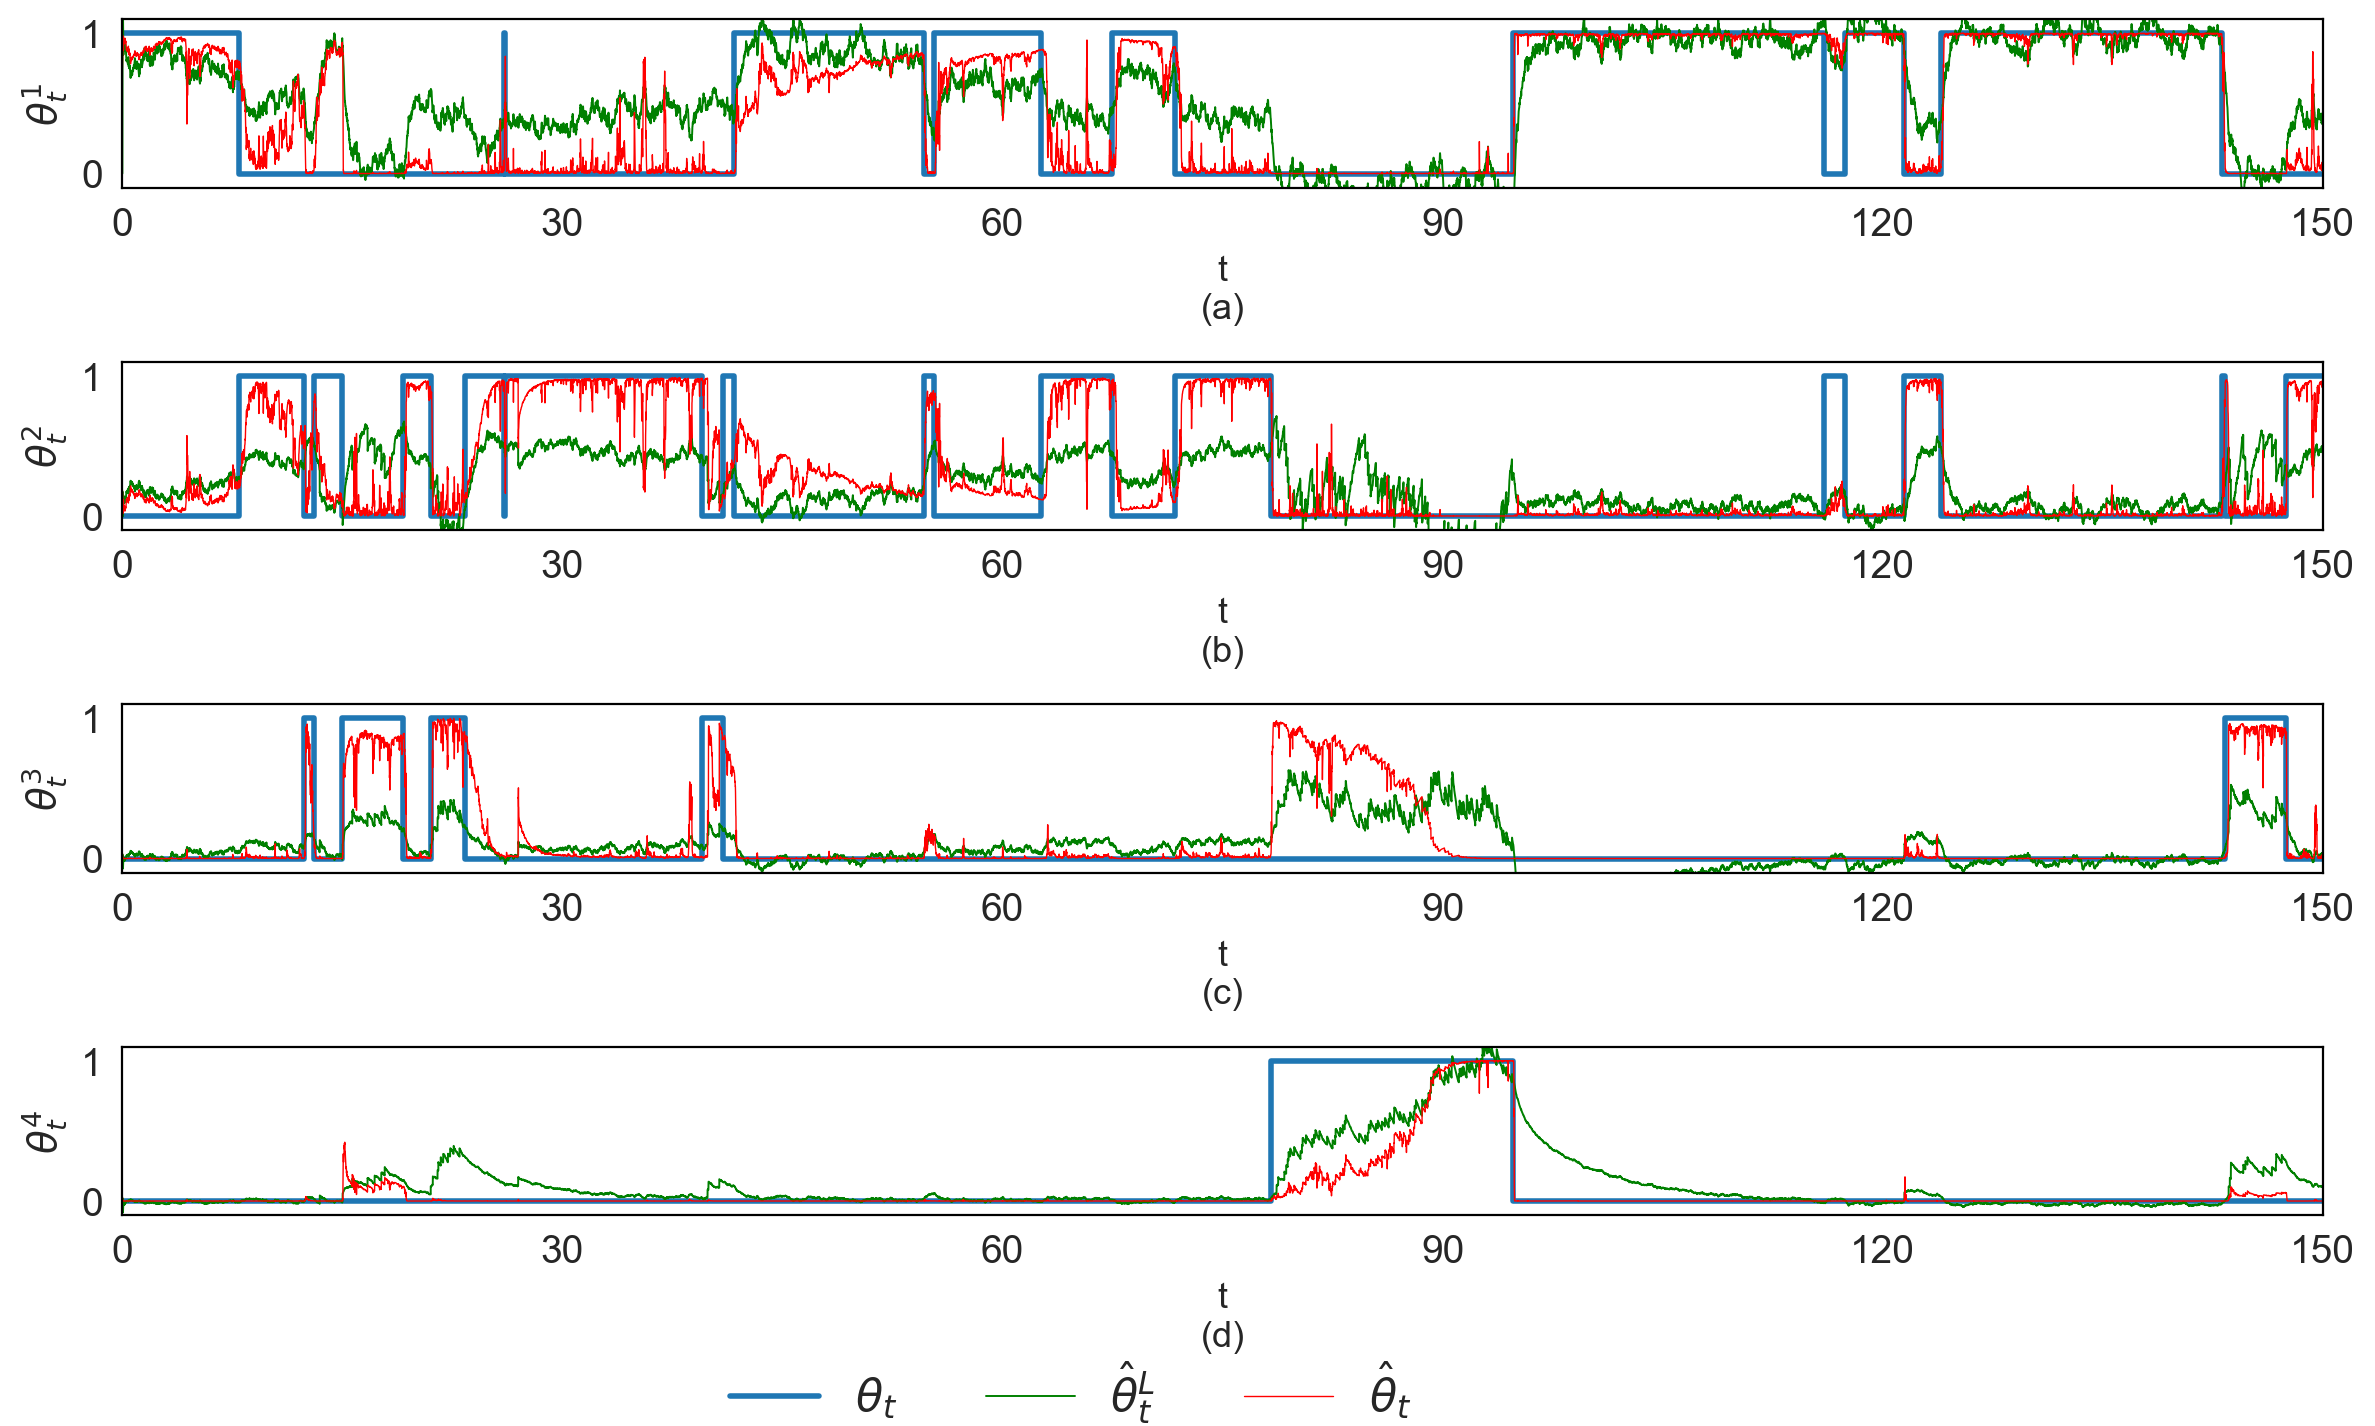

In [27]:
fig, ax = plt.subplots(N, figsize=(12, 7))

T1 = 0
T2 = T

M1 = np.argmin(np.abs(t_net - T1))
M2 = np.argmin(np.abs(t_net - T2))

time_steps = t
marker_style = {'markersize': 2}

for n in range(N):
    theta_i = theta == n

    #line1, = ax[n].plot(time_net, dtmc == n, marker='s', lw=0.5, **marker_style)
    line1, = ax[n].step(np.concatenate([[0], t[:-1], [t[-1]]]),
                        np.concatenate([[theta_i[0]], theta_i[:-1], [theta_i[-1]]]),
                        where='pre', lw=2)
    line2, = ax[n].plot(t_net, theta_l.T[n],
                        color='green', lw=0.7)
    #line3, = ax[n].plot(t_net, theta_opt_2.T[n],
    #                    color='black', lw=1.25)
    
    line4, = ax[n].plot(t_net, theta_opt.T[n],
                        color='red', lw=0.5)
    

    ax[n].set(xlim=(0, T), 
              ylim=(-0.1, 1.1))
    ax[n].set_xlabel('t\n({})'.format(abc[n]), fontsize=13)
    ax[n].set_ylabel('$\\theta_t^{}$'.format(n+1), fontsize=14)
    ax[n].tick_params(labelsize=14)
    ax[n].set_xticks(np.arange(0, T+1, step=30))
    ax[n].set_yticks(ticks=[0, 1])
    ax[n].grid()
    ax[n].spines["bottom"].set_color("k")
    ax[n].spines["top"].set_color("k")
    ax[n].spines["left"].set_color("k")
    ax[n].spines["right"].set_color("k")


fig.legend(fontsize=16,
           handles=[line1, 
                    line2, 
                    #line3,
                    line4
                   ],
           labels=['$\\theta_t$',  
                   '$\\hat \\theta_t^{L}$',
                   #'$\\hat \\theta_t^{c}$',
                   '$\\hat \\theta_t$'
                   ], 
           loc=(0.3, -0.012),
           ncol=4,
           framealpha=1,
           frameon=False)
fig.tight_layout()
plt.show()

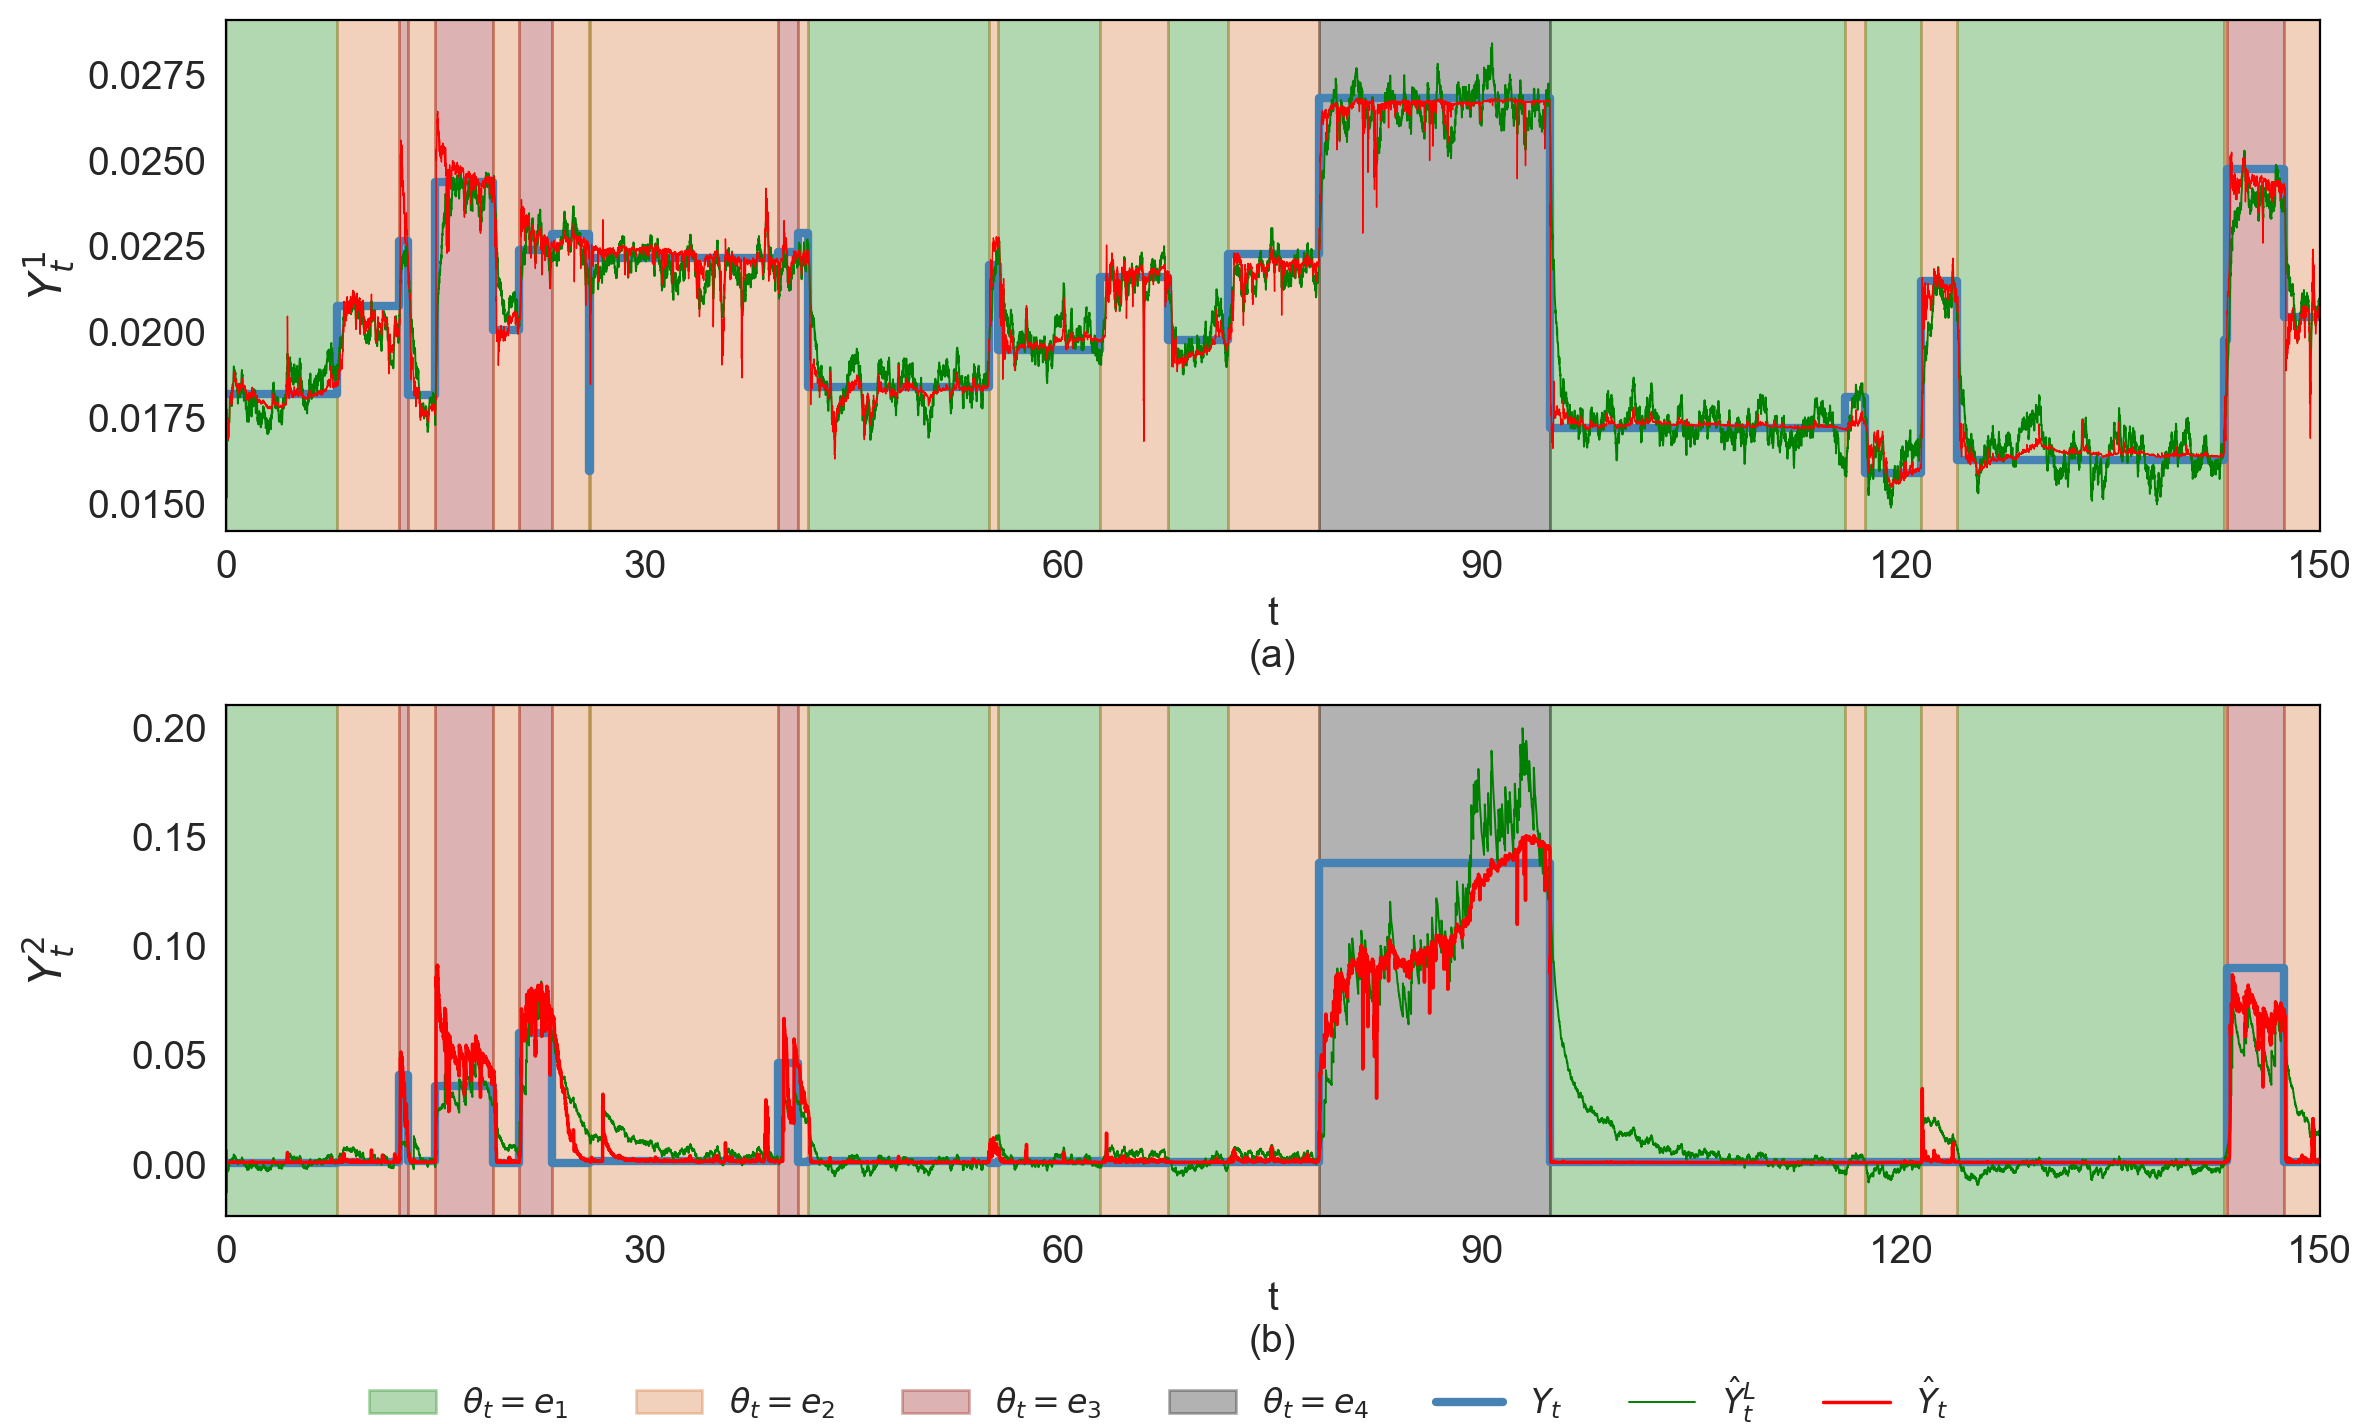

In [28]:
fig, ax = plt.subplots(2, figsize=(12, 7))

T1 = 0
T2 = T

M1 = np.argmin(np.abs(t_net - T1))
M2 = np.argmin(np.abs(t_net - T2))

time_steps = t

lines = []
labels = []


for m in range(M):
    ax[m].set_ylabel('$Y^{}_t$'.format(m+1), fontsize=16)
    y_tmp = y.T[m]
    line1, = ax[m].step(np.concatenate([[0], time_steps[:-1], [T]]), 
                        np.concatenate([[y_tmp[0]], y_tmp[:-1], [y_tmp[-1]]]),
                        where='pre', lw=3, color='steelblue')
    line2, = ax[m].plot(t_net, y_l.T[m], 
                        color='green', lw=0.7)
    #line3, = ax[m].plot(t_net, y_opt_2.T[m], 
    #                    color='black', lw=1.25)
    line4, = ax[m].plot(t_net, y_opt.T[m], 
                        color='red', lw=0.5 + m*0.75)
    

    ax[m].set_xlim(0, T), 
    ax[m].set_xlabel('t\n({})'.format(abc[m]), fontsize=14)
    ax[m].grid()
    ax[m].set_xticks(np.arange(0, T+1, step=30))
    ax[m].set_frame_on(True)
    ax[m].spines["bottom"].set_color("k")
    ax[m].spines["top"].set_color("k")
    ax[m].spines["left"].set_color("k")
    ax[m].spines["right"].set_color("k")
    ax[m].tick_params(labelsize=14)
    
    line1t, line2t, line3t, line4t = plot_theta(ax[m], theta, t, theta_labels, theta_colors, T, alpha=0.3)

#ax[0].set_yticks(np.linspace(0.015, 0.03, num=4))
#ax[1].set_yticks(np.linspace(0, 0.15, num=4))

#handles = [line1t, line1, 
#           line2t, line2, 
#           line3t, line3,
#           line4t]
handles = [line1t, line2t, line3t, line4t,
           line1, 
           line2, 
           #line3, 
           line4]

#labels += [
#           theta_labels[0], '$Y_t$',
#           theta_labels[1], '$\\hat{Y}_t^{c}$', 
#           theta_labels[2], '$\\hat{Y}_t$',
#           theta_labels[3]
#          ]
labels = theta_labels + ['$Y_t$', 
                         '$\\hat{Y}^L_t$', 
                         #'$\\hat{Y}_t^{c}$', 
                         '$\\hat{Y}_t$']

##### 
#x1, x2, y1, y2 = 100, 117, -0.001, 0.041  # subregion of the original image
#axins = ax[1].inset_axes(
#    [0.55, 0.45, 0.25, 0.5],
#    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
#axins.step(np.concatenate([[-0.1], time_steps[:-1], [T]]), 
#           np.concatenate([[y_tmp[0]], y_tmp[:-1], [y_tmp[-1]]]),
#           where='pre', lw=3)
#
#axins.plot(t_net, y_opt_2.T[m], 
#           color='black', lw=1.25)
#axins.plot(t_net, y_opt.T[m], 
#           color='red', lw=0.5)
#
#plot_theta(axins, theta, t, theta_labels, theta_colors, T, alpha=0.2)
#ax[1].indicate_inset_zoom(axins, edgecolor="black")
#axins.grid()
#####

fig.legend(fontsize=12,
           handles=handles, 
           labels=labels, 
           loc=(0.15, -0.01),
           ncol=len(labels), 
           framealpha=1,
           frameon=False)

fig.tight_layout()

fig.align_ylabels()

plt.show()

In [42]:
sigma

0.0005

# СКО

In [29]:
res_theta = pd.read_csv('res_theta_05.csv', index_col=0).to_numpy()
res_y = pd.read_csv('res_y_05.csv', index_col=0).to_numpy()

In [30]:
t_net01 = np.linspace(0, 150, num=1500)

In [31]:
tmp = np.zeros(t_net.shape[0])
for i in range(N):
    tmp += k[:, i, i]

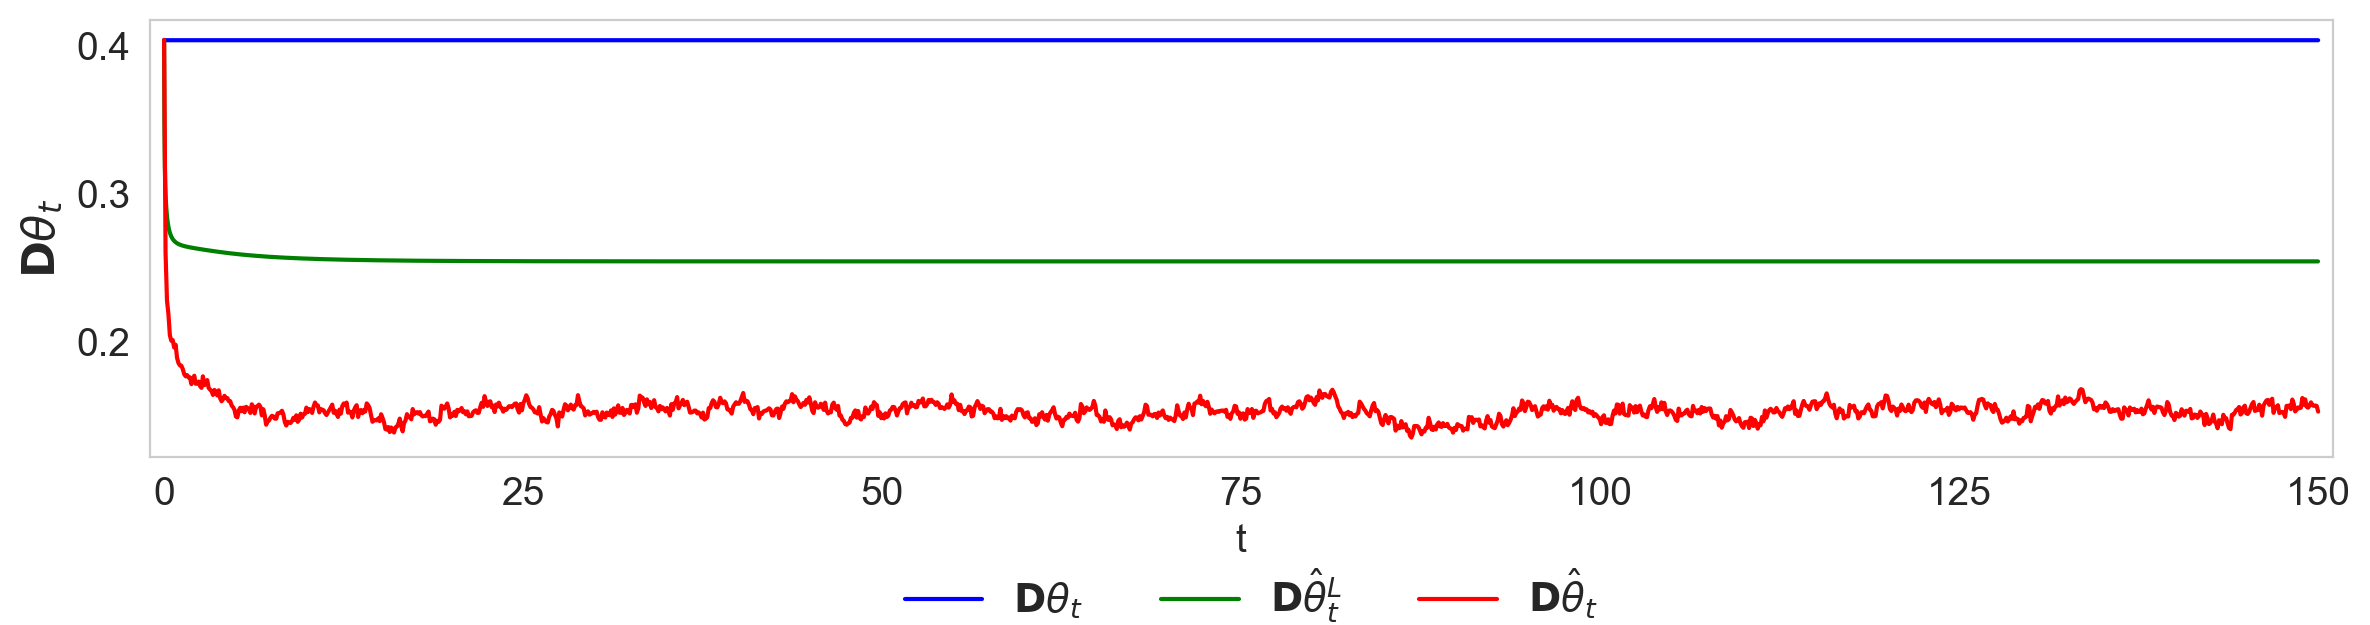

In [32]:
fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(t_net01, np.repeat(np.sum(p0 - p0**2), t_net01.shape[0]), 
        label='$\\mathbf{D}\\theta_t$', color='b')
ax.plot(t_net, tmp, 
        label='$\\mathbf{D} \\hat \\theta_t^L$', color='green')
#ax.plot(t_net01, res_theta_c.T[0], 
#        label='$\\mathbf{D} \\hat \\theta_t^c$', color='k')
ax.plot(t_net01, res_theta.T[0], 
        label='$\\mathbf{D} \\hat \\theta_t$', color='r')


ax.set_ylabel('$\\mathbf{D} \\theta_t$', fontsize=16)


ax.set_xticks(np.arange(0, 151, step=25))
ax.tick_params(labelsize=14)
ax.set_xlim(-1, 151)
ax.set_xlabel('t', fontsize=14)
ax.grid()

fig.tight_layout()
fig.legend(ncols=4,
           loc=(0.375, -0.025),
           frameon=False, 
           fontsize=14)

plt.show()

In [33]:
print(np.mean(tmp))

0.25502483587143876


In [34]:
print(np.sum(p0 - p0**2))

0.40381527777056986


In [35]:
print(np.mean(res_theta))

0.154031888675495


In [36]:
Dy1_u = np.dot(E_y1_sq, p0) - (np.dot(E_y1, p0))**2
Dy2_u = np.dot(E_y2_sq, p0) - (np.dot(E_y2, p0))**2

In [37]:
tmp1 = np.sum(k[:, N:2*N, N:2*N], axis=(1, 2))
tmp2 = np.sum(k[:, 2*N:3*N, 2*N:3*N], axis=(1, 2))

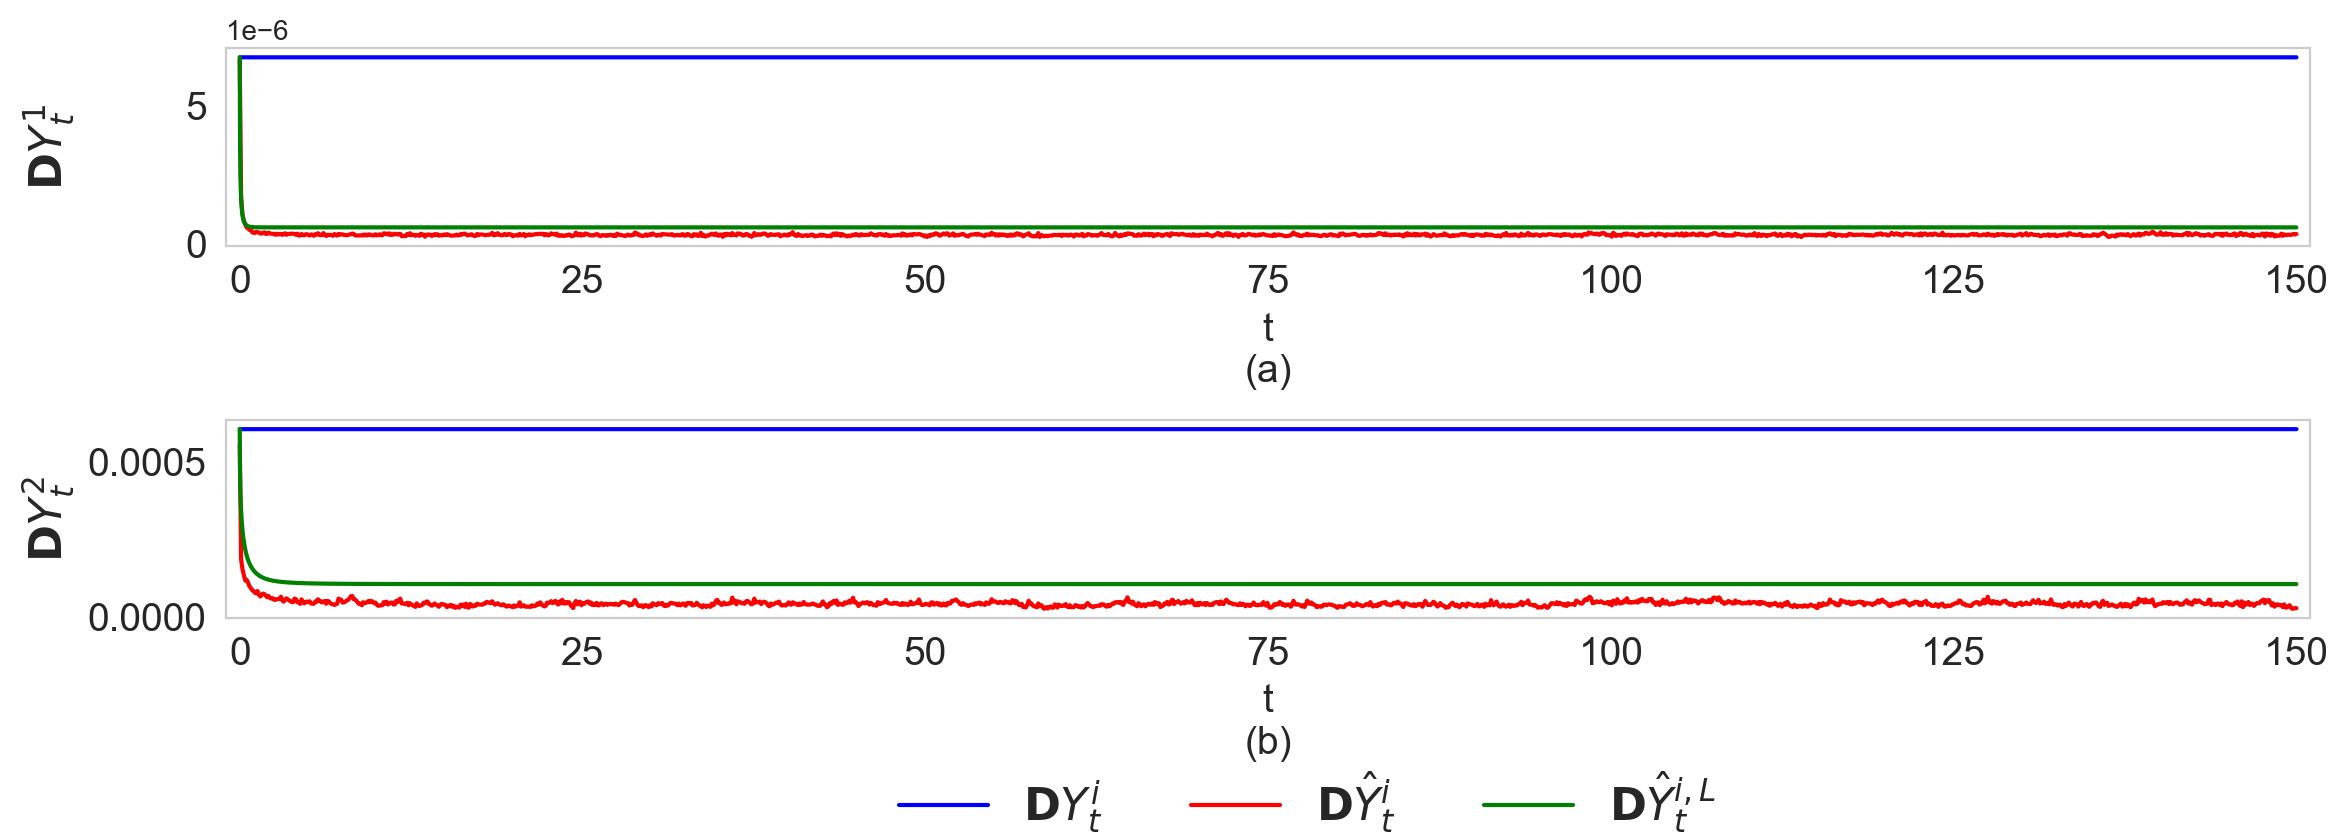

In [38]:
fig, ax = plt.subplots(2, figsize=(12, 4))

line1, = ax[0].plot(t_net01, 
                    np.repeat(Dy1_u, t_net01.shape[0]), 
                    color='b')
line2, = ax[0].plot(t_net01, res_y.T[0], color='r')
#line3, = ax[0].plot(t_net01, res_y_c.T[0], color='k')
line4, = ax[0].plot(t_net, tmp1, color='green')

ax[0].set_xticks(np.arange(0, 151, step=25))
ax[0].tick_params(labelsize=14)
ax[0].set_xlim(-1, 151)
#ax[0].set_ylim(4.3e-6, 7.3e-6)
ax[0].grid()
ax[0].set_ylabel('$\\mathbf{D} Y^1_t$', fontsize=16)
ax[0].set_xlabel(f't\n({abc[0]})', fontsize=14)


ax[1].plot(t_net01, 
           np.repeat(Dy2_u, t_net01.shape[0]),
           color='b')
ax[1].plot(t_net01, res_y.T[1], color='r')
#ax[1].plot(t_net01, res_y_c.T[1], color='k')
ax[1].plot(t_net, tmp2, color='green')

ax[1].set_xticks(np.arange(0, 151, step=25))
ax[1].tick_params(labelsize=14)
ax[1].set_xlim(-1, 151)
ax[1].grid()
ax[1].set_ylabel('$\\mathbf{D} Y^2_t$', fontsize=16)
ax[1].set_xlabel(f't\n({abc[1]})', fontsize=14)


fig.tight_layout()
fig.legend(labels=['$\\mathbf{D} Y^i_t$', 
                   '$\\mathbf{D}\\hat Y^i_t$', 
                   #'$\\mathbf{D}\\hat Y_t^{i,c}$',
                   '$\\mathbf{D}\\hat Y^{i,L}_t$'
                  ],
           handles=[line1, 
                    line2, 
                    #line3, 
                    line4],
           ncols=3,
           loc=(0.375, -0.025),
           frameon=False, 
           fontsize=16)

fig.align_ylabels()

plt.show()

In [39]:
print(np.mean(tmp1))
print(np.mean(tmp2))

5.987835153368941e-07
0.00010778096168251195


In [40]:
print(np.mean(res_y.T[0]))
print(np.mean(res_y.T[1]))

3.3353275522311423e-07
4.470854263264573e-05


In [41]:
print(f'{Dy1_u:f}')
print(f'{Dy2_u:f}')

0.000007
0.000604
